<a href="https://colab.research.google.com/github/SHASHANKV9611/Rice-leaf-disease-prediction/blob/main/Rice_leaf_disease_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [3]:
labels = ['Bacterial leaf blight', 'Brown spot','Leaf smut']
img_size = 200
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train=get_data('/content/drive/MyDrive/Internship/Rice Leaf/Data1/train')
val=get_data('/content/drive/MyDrive/Internship/Rice Leaf/Data1/test')

<ipython-input-3-a8fe0af2589f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [6]:
x_train.shape

(114, 200, 200, 3)

In [7]:
y_train = to_categorical(y_train)
y_train.shape

(114, 3)

In [8]:
y_val=to_categorical(y_val)
y_val.shape

(5, 3)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


In [10]:
#Initialize the model
model =Sequential()

# the shape of the data is (300,300,3) but use X.shape[1:] to get this value dynamically
model.add(Conv2D(32,kernel_size=(3, 3),input_shape=(200,200,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))  #pool_size the window size over which to take the maximum,

model.add(Conv2D(64,kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))

model.add(Dense(3,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [12]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [13]:
class CustomCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs.get('val_accuracy')>=0.80:
            self.model.stop_training = True

stop_early = CustomCallBack()

In [14]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer ='adam',
              metrics =['accuracy'])

history = model.fit(x_train,y_train,steps_per_epoch=4, epochs=50,validation_data=(x_val,y_val),callbacks=[stop_early])

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 1.4553 - accuracy: 0.3509 - val_loss: 1.1214 - val_accuracy: 0.4000
Epoch 2/50
4/4 [==============================] - 9s 2s/step - loss: 1.1048 - accuracy: 0.3158 - val_loss: 1.0782 - val_accuracy: 0.4000
Epoch 3/50
4/4 [==============================] - 9s 3s/step - loss: 1.0915 - accuracy: 0.3158 - val_loss: 1.0901 - val_accuracy: 0.6000
Epoch 4/50
4/4 [==============================] - 7s 2s/step - loss: 1.0137 - accuracy: 0.5526 - val_loss: 1.0789 - val_accuracy: 0.4000
Epoch 5/50
4/4 [==============================] - 9s 3s/step - loss: 0.9450 - accuracy: 0.5614 - val_loss: 1.0230 - val_accuracy: 0.2000
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 0.8786 - accuracy: 0.5614 - val_loss: 1.1176 - val_accuracy: 0.6000
Epoch 7/50
4/4 [==============================] - 9s 2s/step - loss: 0.8215 - accuracy: 0.6491 - val_loss: 0.8108 - val_accuracy: 0.6000
Epoch 8/50
4/4 [=========================

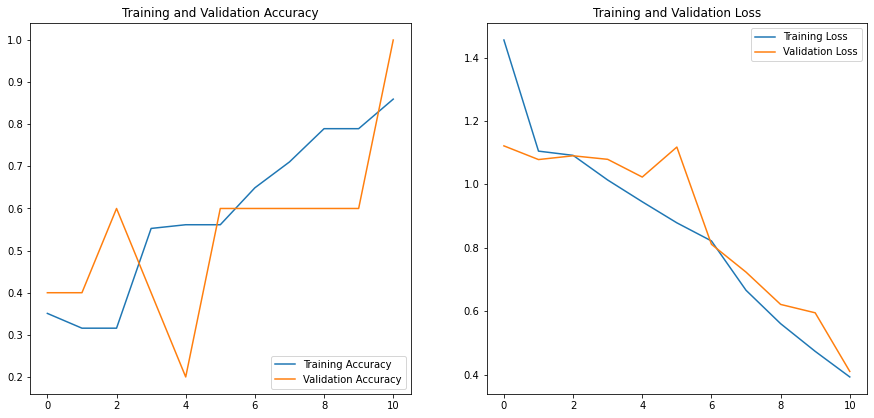

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# get predictions on the test set
y_hat = model.predict(x_val)

labels = ['Bacterial leaf blight', 'Brown spot','Leaf smut']

1/1 [==============================] - 0s 181ms/step


In [18]:
X_new = x_val
y_new = y_val
y_proba = model.predict(X_new)
y_proba
y_proba.round(2)

1/1 [==============================] - 0s 144ms/step


array([[0.87, 0.07, 0.06],
       [0.99, 0.01, 0.  ],
       [0.14, 0.45, 0.4 ],
       [0.26, 0.41, 0.33],
       [0.02, 0.18, 0.8 ]], dtype=float32)

In [19]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred, y_new

(array([0, 0, 1, 1, 2]), array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=float32))

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
img = tf.keras.utils.load_img("/content/DSC_0339.jpg", target_size=(224,224,3)
)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions
score1=np.argmax(score, axis=-1)
score1

In [20]:
score = model.evaluate(x_val, y_val, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 100.0000%


In [21]:
predictions = model.predict(x_val)
predictions[1]

1/1 [==============================] - 0s 97ms/step


array([0.98948085, 0.0093588 , 0.00116037], dtype=float32)

In [22]:
y_predict = np.argmax(predictions,axis=1)
y_true = np.argmax(y_val,axis=1)
print(classification_report(y_true,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [ ]:
y_hat = model.predict(x_val)
Rice_labels= ['Leaf Smut','Bacterial Leaf Blight','Brown Spot']

In [ ]:

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_val.shape[0], size=32)):
    ax = fig.add_subplot(20, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(x_val[idx])
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_val[idx])
    ax.set_title("{} ({})".format(Rice_labels[pred_idx], Rice_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))